In [111]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from enum import Enum, auto
from copy import deepcopy as cpy
from dataclasses import dataclass, field

@dataclass
class PsfWaveformSpec:
  fo_hz: float
  fs_hz: float
  samples_n: int
  ph_rad: float = 0
  amp: float = 1
  power: float = 0

@dataclass
class PsfWaveformData(PsfWaveformSpec):
  power_time: float = 0
  power_freq: float = 0


# Waveform Generators.
def psf_sine(spec: PsfWaveformSpec):
  amp = 0 if spec.amp < 0 else 1 if spec.amp > 1 else spec.amp
  n = np.arange(spec.samples_n) 
  return amp * np.sin((2 * np.pi * spec.fo_hz * n / spec.fs_hz) + spec.ph_rad)

def psf_square(spec: PsfWaveformSpec):
  amp = 0 if spec.amp < 0 else 1 if spec.amp > 1 else spec.amp
  n = np.arange(spec.samples_n) 
  return amp * signal.square(2 * np.pi * spec.fo_hz * n / spec.fs_hz + + spec.ph_rad, .5) 
  
def psf_tri(spec: PsfWaveformSpec):
  amp = 0 if spec.amp < 0 else 1 if spec.amp > 1 else spec.amp
  n = np.arange(spec.samples_n) 
  return amp * signal.sawtooth(2 * np.pi * spec.fo_hz * n / spec.fs_hz + + spec.ph_rad, .5) 

def psf_delta(spec: PsfWaveformSpec):
  amp = 0 if spec.amp < 0 else 1 if spec.amp > 1 else spec.amp
  sn = np.zeros(spec.samples_n) 
  sn[0] = 1.0
  return sn



# Utilities.
def psf_spec_to_time_sec(spec: PsfWaveformSpec):
  return np.arange(spec.samples_n) * 1/spec.fs_hz

def psf_gen_cont_and_disc_wvfm(spec: PsfWaveformSpec, fun=psf_sine):
  spec_cont = cpy(spec)
  spec_cont.fs_hz = spec_cont.fs_hz * 100
  spec_cont.samples_n = spec_cont.samples_n * 100
  return (psf_spec_to_time_sec(spec), fun(spec)), (psf_spec_to_time_sec(spec_cont), fun(spec_cont))  

def easy_fft(x, fs):
    fft = np.abs(np.fft.fftshift(np.fft.fft(x)/len(x)))
    fft_fs = np.fft.fftshift(np.fft.fftfreq(len(x), 1/fs))
    return fft, fft_fs

def get_avg_power_f(X):
  return np.sum(abs(X)**2)

def get_avg_power_t(x):
  return np.sum(x**2) / len(x)



avg_power_f:0.9999999999999999
avg_power_t:1.0
avg_power_f:0.5
avg_power_t:0.5
avg_power_f:0.3336
avg_power_t:0.3336
avg_power_f:0.002
avg_power_t:0.002


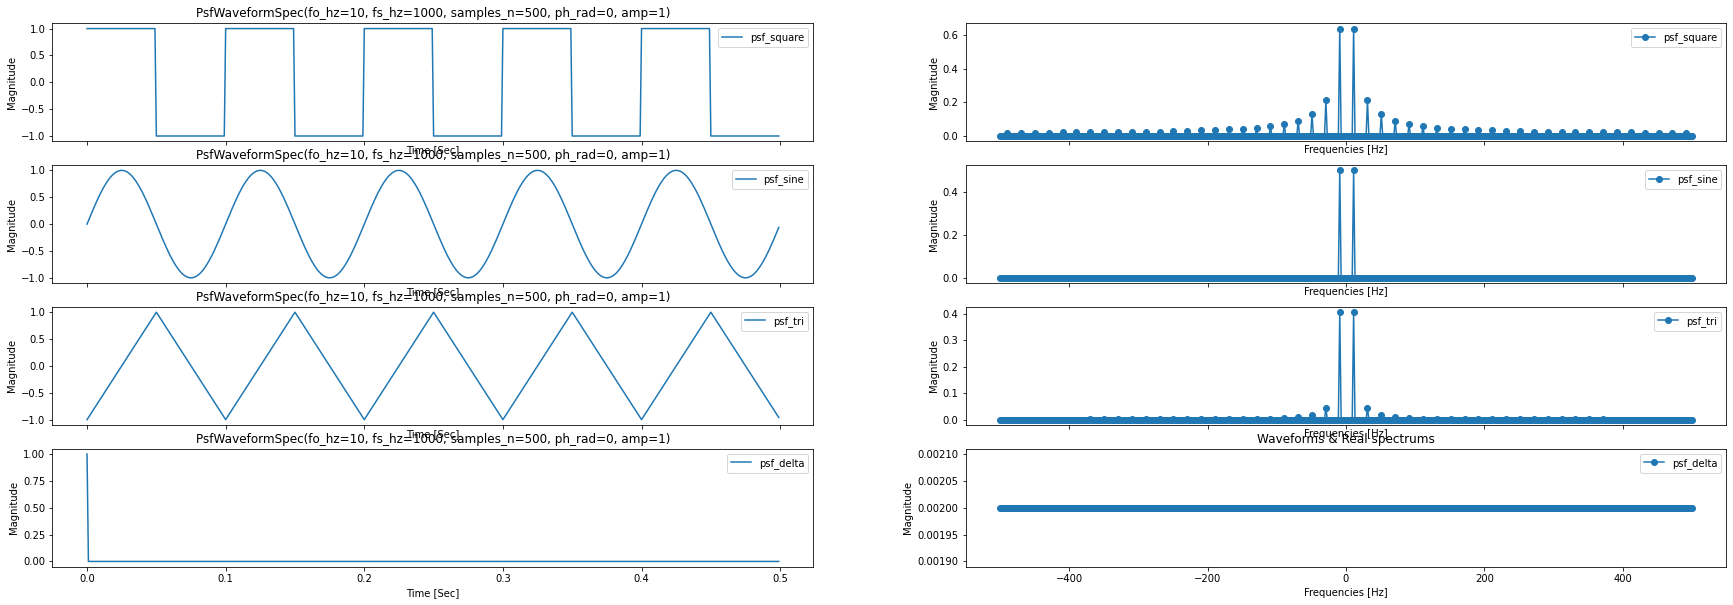

In [118]:
def get_avg_power(spectrum):
  return np.sqrt(np.sum(spectrum**2))

wfm = PsfWaveformSpec(
    fo_hz = 10,
    fs_hz = 1000,
    samples_n = 500,
    ph_rad = 0,
    amp = 1
)

waveforms = (psf_square, psf_sine, psf_tri, psf_delta)

fig, axs = plt.subplots(len(waveforms), 2 , figsize=(30, 10), sharex='col')


for i, fun in enumerate((psf_square, psf_sine, psf_tri, psf_delta)):
  time = np.arange(0, wfm.samples_n) * 1/wfm.fs_hz
  sig = fun(wfm)
  fft = np.abs(np.fft.fftshift(np.fft.fft(sig)/len(sig)))
  fft_fs = np.linspace(-wfm.fs_hz / 2, wfm.fs_hz / 2, wfm.samples_n)
  
  d = PsfWaveformData(power_freq=get_avg_power_f(fft), power_time=get_avg_power_t(sig),  **wfm.__dict__)
  axs[i, 0].plot(time, sig, label=fun.__name__)
  axs[i, 0].legend()
  axs[i, 0].set_xlabel('Time [Sec]')
  axs[i, 0].set_ylabel('Magnitude')
  axs[i, 0].set_title(str(d))
  axs[i, 1].plot(fft_fs, fft, '-o', label=fun.__name__)
  axs[i, 1].legend()
  axs[i, 1].set_xlabel('Frequencies [Hz]')
  axs[i, 1].set_ylabel('Magnitude')

  # axs[i, 1].set_xticks(np.arange(-wfm.fs_hz / 2, wfm.fs_hz / 2, wfm.fo_hz))

plt.title('Waveforms & Real spectrums')
plt.show()





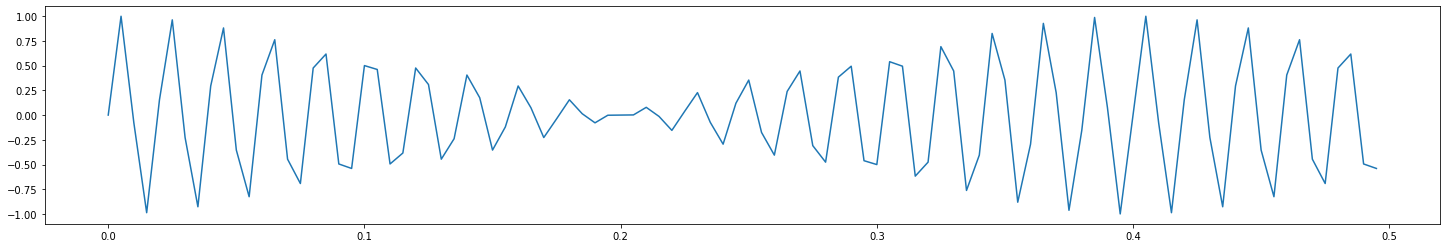

No handles with labels found to put in legend.


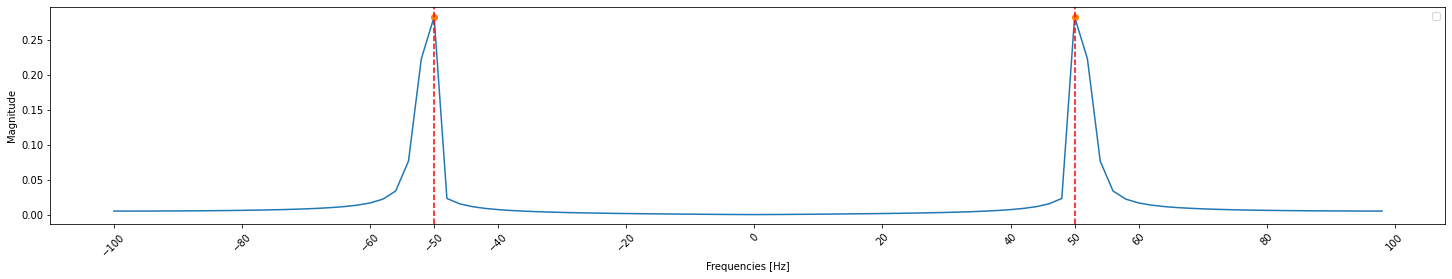

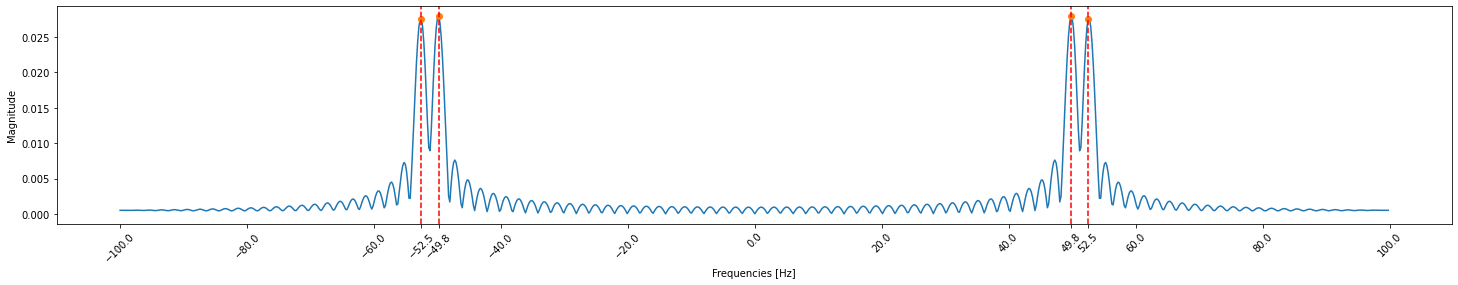

{'peak_heights': array([0.02759321, 0.02793229, 0.02793229, 0.02759321])}


In [110]:
import numpy as np
import scipy

def easy_fft(signal, fs):
    fft = np.abs(np.fft.fftshift(np.fft.fft(signal)/len(signal)))
    fft_fs = np.fft.fftshift(np.fft.fftfreq(len(signal), 1/fs))
    return fft, fft_fs


FS = 200
PSF_FILE = './data/resolucion_espectral.txt' 
PADDING_SIG_LEN_MULT = 5

with open(PSF_FILE) as f:
    sig = np.array(eval(f.read()))
    time = np.arange(len(sig)) * 1/FS

sig_padded = np.concatenate((sig, np.zeros(924)))

plt.figure(figsize=(25,4))
plt.plot(time, sig)
plt.show()

plt.figure(figsize=(25,4))
fft, freqs = easy_fft(sig, FS)
peaks_ind, peaks = scipy.signal.find_peaks(fft, height=0.15)
peaks_fs = [freqs[i] for i in peaks_ind]
peaks_vals = peaks['peak_heights']
plt.plot(freqs, fft)
plt.plot(peaks_fs, peaks_vals, 'o')
for f in peaks_fs:
    plt.axvline(x=f, color='r', linestyle='--')
plt.xticks(np.concatenate((np.linspace(-100, 100, 11), peaks_fs)), rotation=45)
plt.legend()
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Magnitude')
plt.show()


plt.figure(figsize=(25,4))
fft, freqs = easy_fft(sig_padded, FS)
peaks_ind, peaks = scipy.signal.find_peaks(fft, height=0.02)
peaks_fs = [freqs[i] for i in peaks_ind]
peaks_vals = peaks['peak_heights']
plt.plot(freqs, fft)
plt.plot(peaks_fs, peaks_vals, 'o')
for f in peaks_fs:
    plt.axvline(x=f, color='r', linestyle='--')
plt.xticks(np.concatenate((np.linspace(-100, 100, 11), peaks_fs)), rotation=45)
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Magnitude')
plt.show()
print(peaks)




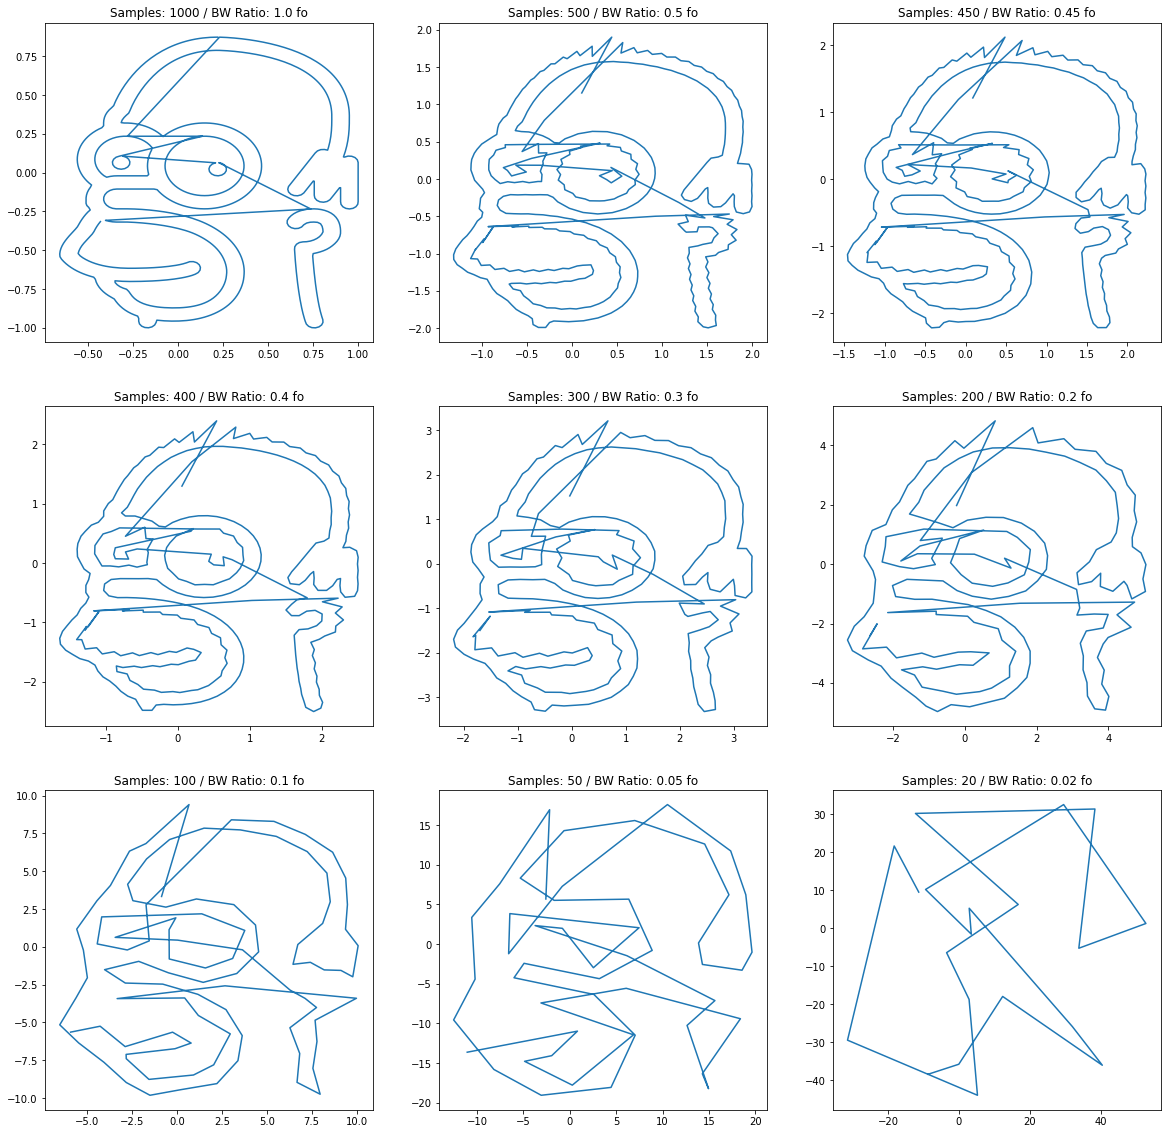

In [94]:
import numpy as np
sig_spectrum = np.load('./data/fft_hjs.npy')

def ifft_2d(x):
    sig = np.fft.ifft(x)
    return (np.imag(sig), np.real(sig))

def spectrum_truncate(x, n):
    return np.concatenate((x[:n], x[len(x)-n:]))
    

test_points =(500, 250, 225, 200, 150, 100, 50, 25, 10)
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
for i in range(3):
    for j in range(3):
        x, y = ifft_2d(spectrum_truncate(sig_spectrum, test_points[3*i + j]))
        axs[i, j].plot(x, y)
        axs[i, j].set_title(f'Samples: {2 * test_points[3*i + j]} / BW Ratio: {test_points[3*i + j] / 500} fo')
plt.show()




